# Pertrain Model Faster R-CNN

Show example of a pair of images and segmentation masks

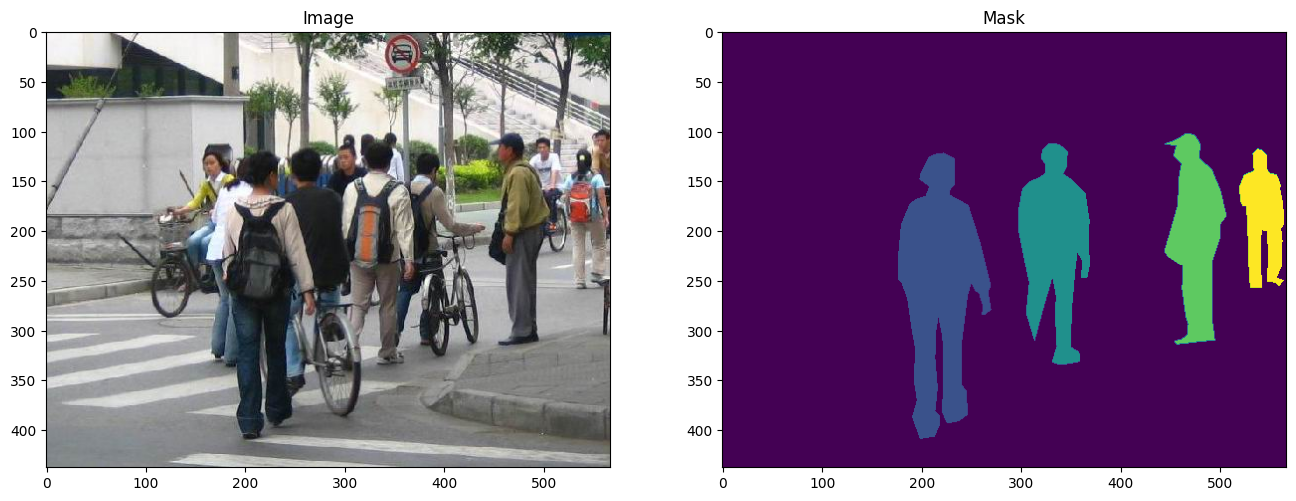

In [1]:
import matplotlib.pyplot as plt
from torchvision.io import read_image

image = read_image("../data/PennFudanPed/PNGImages/FudanPed00046.png")
mask = read_image("../data/PennFudanPed/PedMasks/FudanPed00046_mask.png")

plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.title("Image")
plt.imshow(image.permute(1, 2, 0))
plt.subplot(122)
plt.title("Mask")
plt.imshow(mask.permute(1, 2, 0))


## Load Data Set

In [2]:
import os
import numpy as np
import torch
from PIL import Image
import utils

class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)
        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.nonzero(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

## Data Augmentation

In [3]:
import torchvision.transforms as T
from torchvision.transforms import functional as F

class ComposeWithTarget:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

class ToTensorWithTarget:
    def __call__(self, image, target):
        image = F.to_tensor(image)
        return image, target

class RandomHorizontalFlipWithTarget:
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, image, target):
        if torch.rand(1) < self.p:
            image = F.hflip(image)
            # Flip the bounding boxes along the x-axis
            bbox = target["boxes"]
            width, _ = F.get_image_size(image)
            bbox[:, [0, 2]] = width - bbox[:, [2, 0]]
            target["boxes"] = bbox
        return image, target

# Custom transformation pipeline
def get_transform(train=True):
    transforms = []
    transforms.append(ToTensorWithTarget())
    if train:
        transforms.append(RandomHorizontalFlipWithTarget(p=0.5))
    return ComposeWithTarget(transforms)


In [4]:
def collate_fn(batch):
    return tuple(zip(*batch))

## Simple test

In [5]:
dataset = PennFudanDataset('../data/PennFudanPed', get_transform(train=True))

data_loader = torch.utils.data.DataLoader(
 dataset, batch_size=2, shuffle=True, num_workers=4,
 collate_fn=collate_fn)

In [6]:
import torchvision

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

images,targets = next(iter(data_loader))

images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

output = model(images,targets)   # Returns losses and detections
print(output)

{'loss_classifier': tensor(0.1680, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0796, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0375, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)}


## Training Function

In [7]:
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10, scaler=None):
    model.train()
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter("lr", utils.SmoothedValue(window_size=1, fmt="{value:.6f}"))
    header = f"Epoch: [{epoch}]"

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor=warmup_factor, total_iters=warmup_iters
        )

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass and loss calculation
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass and optimizer step
        optimizer.zero_grad()
        if scaler is not None:
            scaler.scale(losses).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            losses.backward()
            optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses, **loss_dict)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])
    
    return metric_logger

## Evaluate Function

In [8]:
# Custom evaluation function
def evaluate(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0
    iou_threshold = 0.5  # Set IoU threshold for accuracy
    
    metric_logger = utils.MetricLogger(delimiter="  ")
    header = "Test:"

    with torch.no_grad():
        for images, targets in metric_logger.log_every(data_loader, 10, header):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            outputs = model(images)  # Get predictions

            for i, output in enumerate(outputs):
                pred_boxes = output['boxes'].cpu()
                true_boxes = targets[i]['boxes'].cpu()

                # Calculate Intersection over Union (IoU) for accuracy
                ious = torchvision.ops.box_iou(pred_boxes, true_boxes)
                correct += (ious.max(dim=0)[0] > iou_threshold).sum().item()
                total += len(true_boxes)

            accuracy = correct / total if total > 0 else 0
            metric_logger.update(accuracy=accuracy)

    final_accuracy = correct / total if total > 0 else 0
    print(f"Final Accuracy: {final_accuracy:.4f}")


In [9]:
def main():
    # train on the GPU or on the CPU, if a GPU is not available
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    # our dataset has two classes only - background and person
    num_classes = 2
    # use our dataset and defined transformations
    dataset = PennFudanDataset('../data/PennFudanPed', get_transform(train=True))
    dataset_test = PennFudanDataset('../data/PennFudanPed', get_transform(train=False))

    # split the dataset in train and test set
    indices = torch.randperm(len(dataset)).tolist()
    dataset = torch.utils.data.Subset(dataset, indices[:-50])
    dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

    # define training and validation data loaders
    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=2, shuffle=True, num_workers=4,
        collate_fn=collate_fn)

    data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=1, shuffle=False, num_workers=4,
        collate_fn=collate_fn)

    # move model to the right device
    model.to(device)

    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)
    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)

    # let's train it for 10 epochs
    num_epochs = 10

    for epoch in range(num_epochs):
        train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
        # update the learning rate
        lr_scheduler.step()
        evaluate(model, data_loader_test, device=device)
        # print(f"Epoch [{epoch + 1}/{num_epochs}], Accuracy: {accuracy:.4f}")

    print("That's it!")

main()

Epoch: [0]  [ 0/60]  eta: 0:00:33  lr: 0.000090  loss: 0.2751 (0.2751)  loss_classifier: 0.2008 (0.2008)  loss_box_reg: 0.0502 (0.0502)  loss_objectness: 0.0126 (0.0126)  loss_rpn_box_reg: 0.0116 (0.0116)  time: 0.5578  data: 0.1496  max mem: 3582
Epoch: [0]  [10/60]  eta: 0:00:18  lr: 0.000936  loss: 0.2272 (0.2493)  loss_classifier: 0.1478 (0.1581)  loss_box_reg: 0.0502 (0.0591)  loss_objectness: 0.0251 (0.0267)  loss_rpn_box_reg: 0.0033 (0.0055)  time: 0.3781  data: 0.0171  max mem: 4019
Epoch: [0]  [20/60]  eta: 0:00:14  lr: 0.001783  loss: 0.1656 (0.1930)  loss_classifier: 0.0859 (0.1119)  loss_box_reg: 0.0480 (0.0582)  loss_objectness: 0.0120 (0.0181)  loss_rpn_box_reg: 0.0031 (0.0048)  time: 0.3644  data: 0.0039  max mem: 4019
Epoch: [0]  [30/60]  eta: 0:00:11  lr: 0.002629  loss: 0.1054 (0.1678)  loss_classifier: 0.0402 (0.0884)  loss_box_reg: 0.0480 (0.0611)  loss_objectness: 0.0025 (0.0133)  loss_rpn_box_reg: 0.0032 (0.0050)  time: 0.3761  data: 0.0039  max mem: 4023
Epoch: [

## Predict

In [10]:
def predict(model, image, device, threshold=0.5):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        # Transform the image to tensor and send it to the device
        transform = T.Compose([T.ToTensor()])
        image_tensor = transform(image).unsqueeze(0).to(device)  # Add a batch dimension

        # Perform inference
        output = model(image_tensor)

        # Get the predicted bounding boxes, labels, and scores
        boxes = output[0]['boxes'].cpu().numpy()
        labels = output[0]['labels'].cpu().numpy()
        scores = output[0]['scores'].cpu().numpy()

        # Filter predictions based on the threshold
        boxes = boxes[scores >= threshold]
        labels = labels[scores >= threshold]
        scores = scores[scores >= threshold]

        return boxes, labels, scores

# Helper function to visualize the predictions
def plot_predictions(image, boxes, labels, scores, class_names, threshold=0.5):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    ax = plt.gca()

    # Add the predicted bounding boxes and labels to the image
    for box, label, score in zip(boxes, labels, scores):
        xmin, ymin, xmax, ymax = box
        width, height = xmax - xmin, ymax - ymin
        color = "red"
        rect = plt.Rectangle((xmin, ymin), width, height, fill=False, color=color, linewidth=2)
        ax.add_patch(rect)
        text = f"{class_names[label]}: {score:.2f}"
        ax.text(xmin, ymin - 10, text, color=color, fontsize=12, bbox=dict(facecolor='yellow', alpha=0.5))

    plt.axis('off')
    plt.show()

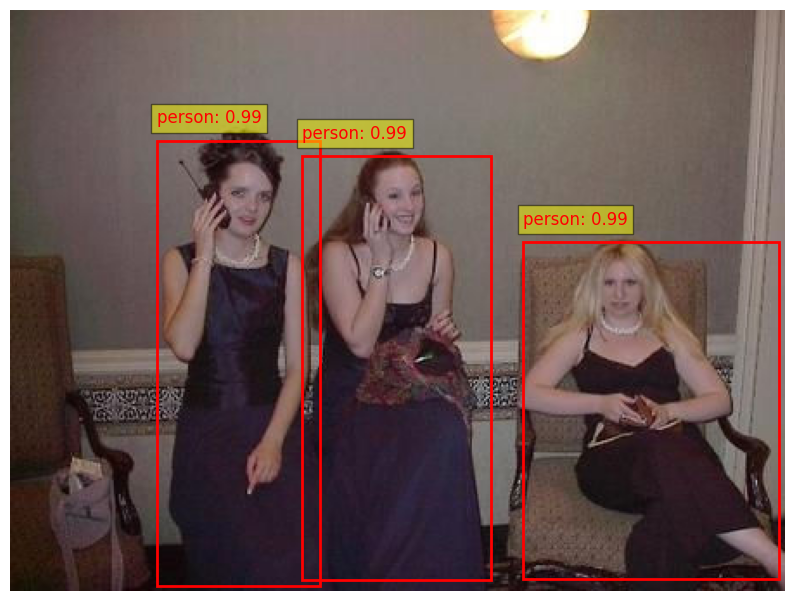

In [11]:
class_names = ['background', 'person']

image_path = '../data/coco/val2014/COCO_val2014_000000000536.jpg'
image = Image.open(image_path).convert('RGB')

boxes, labels, scores = predict(model, image, device, threshold=0.5)

plot_predictions(image, boxes, labels, scores, class_names)